## RNN, LSTMを使った株価予測

RNNやLSTMは時系列データの予測のために利用されます。時系列データには、ある場所の気温や、来客数、商品の価格など多岐にわたりますが、最もデータを入手しやすい株価をRNNとLSTMで予測を行ってみたいと思います。

ただし、ニューラルネットはあくまでも得られたデータの範囲内でしか予測する事が出来ず、想定外の状況になった場合、そのモデルはほぼ意味をなしません。例えば、コロナショック前の1年前のデータを用いても、コロナショックを予測する事は出来ません。

また、株価の形成はテクニカルな要素だけでなく、ファンダメンタルズ、実需や先物などの複雑な要素もあり、LSTMで未来を予測するのは難しいとは思います。とはいえ、面白そうなので、年末の時間を利用してLSTMに慣れるためにもやってみようと思います。

あくまでもRNNやLSTMに慣れる練習の一環ですので、この結果をもって株価が予測できるなどとは思わないでください。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_stock/lstm_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_stock/lstm_nb.ipynb)

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6032


In [2]:
!python -V

Python 3.8.5


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

matplotlib version : 3.3.2
scipy version : 1.5.2
numpy version : 1.18.5
tensorflow version :  2.3.1
keras version :  2.4.0


## データの取得

今回は日経平均とアメリカのS&P500の株価のデータの予測を行います。データはそれぞれ以下のサイトからダウンロードしました。

### 日経平均のデータ

- https://indexes.nikkei.co.jp/nkave/index?type=download

### SP500のデータ

- https://kabuoji3.com/stock/download.php


## 日経平均の予測

### データの確認
まず最初に日経のデータを見てみます。

In [4]:
!ls 

files_bk             lstm_nb.md           lstm_nb.txt          nikkei.csv           sp500_2019.csv       sp500_2019_utf8.csve sp500_2020_utf8.csv
lstm_nb.ipynb        lstm_nb.py           lstm_nb_files        nikkei_utf8.csv      sp500_2019_utf8.csv  sp500_2020.csv       sp500_2020_utf8.csve


In [5]:
%%bash
head nikkei.csv

�f�[�^���t,�I�l,�n�l,���l,���l
"2017/01/04","19594.16","19298.68","19594.16","19277.93"
"2017/01/05","19520.69","19602.10","19615.40","19473.28"
"2017/01/06","19454.33","19393.55","19472.37","19354.44"
"2017/01/10","19301.44","19414.83","19484.90","19255.35"
"2017/01/11","19364.67","19358.64","19402.17","19325.46"
"2017/01/12","19134.70","19300.19","19300.19","19069.02"
"2017/01/13","19287.28","19174.97","19299.36","19156.93"
"2017/01/16","19095.24","19219.13","19255.41","19061.27"
"2017/01/17","18813.53","19038.45","19043.91","18812.86"


文字コードがshift-jisになっているので、utf-8に直します。

In [6]:
%%bash
nkf --guess nikkei.csv

Shift_JIS (LF)


In [7]:
%%bash
nkf -w nikkei.csv > nikkei_utf8.csv

In [8]:
%%bash
head nikkei_utf8.csv

データ日付,終値,始値,高値,安値
"2017/01/04","19594.16","19298.68","19594.16","19277.93"
"2017/01/05","19520.69","19602.10","19615.40","19473.28"
"2017/01/06","19454.33","19393.55","19472.37","19354.44"
"2017/01/10","19301.44","19414.83","19484.90","19255.35"
"2017/01/11","19364.67","19358.64","19402.17","19325.46"
"2017/01/12","19134.70","19300.19","19300.19","19069.02"
"2017/01/13","19287.28","19174.97","19299.36","19156.93"
"2017/01/16","19095.24","19219.13","19255.41","19061.27"
"2017/01/17","18813.53","19038.45","19043.91","18812.86"


問題ないようなので、pandasで読み込みます。

In [9]:
df = pd.read_csv('nikkei_utf8.csv')

In [10]:
df.head()

,データ日付,終値,始値,高値,安値
0,2017/01/04,19594.16,19298.68,19594.16,19277.93
1,2017/01/05,19520.69,19602.10,19615.40,19473.28
2,2017/01/06,19454.33,19393.55,19472.37,19354.44
3,2017/01/10,19301.44,19414.83,19484.90,19255.35
4,2017/01/11,19364.67,19358.64,19402.17,19325.46


In [11]:
df.tail()

,データ日付,終値,始値,高値,安値
971,2020/12/24,26668.35,26635.11,26764.53,26605.26
972,2020/12/25,26656.61,26708.10,26716.61,26638.28
973,2020/12/28,26854.03,26691.29,26854.03,26664.60
974,2020/12/29,27568.15,26936.38,27602.52,26921.14
975,本資料は日経の著作物であり、本資料の全部又は一部を、いかなる形式によっても日経に無断で複写、...,NaN,NaN,NaN,NaN


最後の行に著作権に関する注意書きがありますが、これを削除します。複写や流布は行いません。

In [12]:
df.drop(index=975, inplace=True)

In [13]:
df.tail()

,データ日付,終値,始値,高値,安値
970,2020/12/23,26524.79,26580.43,26585.21,26414.74
971,2020/12/24,26668.35,26635.11,26764.53,26605.26
972,2020/12/25,26656.61,26708.10,26716.61,26638.28
973,2020/12/28,26854.03,26691.29,26854.03,26664.60
974,2020/12/29,27568.15,26936.38,27602.52,26921.14


データを可視化してみます。コロナショックで大きくへこんでいることがわかりますが、2020年の年末の時点では金融緩和の影響を受けて大幅に上がっています。

### データの整形

最初のデータを基準に、その値からの変化率を計算し、そのリストに対して学習を行います。

In [14]:
def shape_data(data_list):
  return [d / data_list[0] - 1 for d in data_list]

df['data_list'] = shape_data(df['終値'])

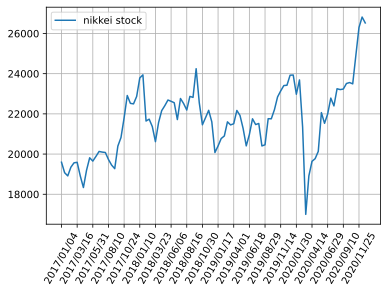

In [15]:
ticks = 10
xticks = ticks * 5 

plt.plot(df['データ日付'][::ticks], df['終値'][::ticks], label='nikkei stock')
plt.grid()
plt.legend()
plt.xticks(df['データ日付'][::xticks], rotation=60)
plt.show()

比率に直したグラフも示しておきます。

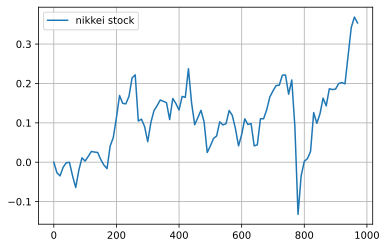

In [16]:
plt.plot(df.index.values[::ticks], df['data_list'][::ticks], label='nikkei stock')
plt.grid()
plt.legend()
plt.show()

### 定数の準備

In [17]:
# データとしては約四年分あるが、今回はこれを8このパートに分けて、それぞれの領域で予想を行う
TERM_PART_LIST = [0, 120, 240, 360, 480, 600, 720, 840]

# 予測に利用するデータ数
# 90個のデータから後の30個のデータを予測する
NUM_LSTM = 90

# 中間層の数
NUM_MIDDLE = 200

# ニューラルネットのモデルの定数
batch_size = 100
epochs = 2000
validation_split = 0.25

### データの準備

kerasに投入するためにデータを整えます。

In [18]:
def get_x_y_lx_ly(term_part):
  
  date = np.array(df['データ日付'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
  x = np.array(df.index.values[TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
  y = np.array(df['data_list'][TERM_PART_LIST[term_part]: TERM_PART_LIST[term_part + 1]])
  
  n = len(y) - NUM_LSTM
  l_x = np.zeros((n, NUM_LSTM))
  l_y = np.zeros((n, NUM_LSTM))
  
  for i in range(0, n):
    l_x[i] = y[i: i + NUM_LSTM]
    l_y[i] = y[i + 1: i + NUM_LSTM + 1]
  
  l_x = l_x.reshape(n, NUM_LSTM, 1)
  l_y = l_y.reshape(n, NUM_LSTM, 1)
  
  return n, date, x, y, l_x, l_y

n, date, x, y, l_x, l_y = get_x_y_lx_ly(0)

In [19]:
print('shape : ', x.shape)
print('ndim : ', x.ndim)
print('data : ', x[:10])

shape :  (120,)
ndim :  1
data :  [0 1 2 3 4 5 6 7 8 9]


In [20]:
print('shape : ', y.shape)
print('ndim : ', y.ndim)
print('data : ', y[:10])

shape :  (120,)
ndim :  1
data :  [ 0.         -0.00374959 -0.00713631 -0.01493915 -0.01171216 -0.02344882
 -0.01566181 -0.02546269 -0.03983993 -0.03571421]


In [21]:
print(l_y.shape)
print(l_x.shape)

(30, 90, 1)
(30, 90, 1)


### モデルの構築

モデルの構築を定義する関数です。デフォルトではRNNとします。

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU


def build_model(model_name='RNN'):
  # LSTMニューラルネットの構築
  model = Sequential()
  
  # RNN,LSTM、GRUを選択できるようにする
  if model_name == 'RNN':
    model.add(SimpleRNN(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  if model_name == 'LSTM':
    model.add(LSTM(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  if model_name == 'GRU':
    model.add(GRU(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  
  model.add(Dense(1, activation="linear"))
  model.compile(loss="mean_squared_error", optimizer="sgd")
  
  return model


# ニューラルネットを深くした（今回は使わない）
def build_model_02(): 
  
  NUM_MIDDLE_01 = 100
  NUM_MIDDLE_02 = 120
  
  # LSTMニューラルネットの構築
  model = Sequential()
  model.add(LSTM(NUM_MIDDLE_01, input_shape = (NUM_LSTM, 1), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(NUM_MIDDLE_02, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.add(Activation("linear"))
  model.compile(loss="mean_squared_error", optimizer="sgd")
  # model.compile(loss="mse", optimizer='rmsprop')
    
  return model
  
model = build_model('RNN')

### モデルの詳細

In [23]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 90, 200)           40400     
_________________________________________________________________
dense (Dense)                (None, 90, 1)             201       
Total params: 40,601
Trainable params: 40,601
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
# validation_split で最後の10％を検証用に利用します
history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)

### 損失関数の可視化

学習によって誤差が減少していく様子を可視化してみます。今のエポック数で収束しているように見えます。

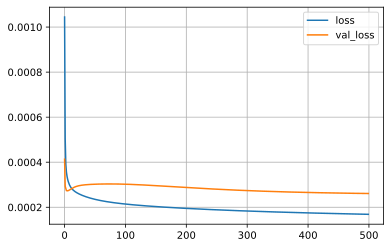

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.grid()
plt.legend()
plt.show()

### RNNによる結果の確認

薄いオレンジに塗りつぶされた期間が予測のために利用した期間です。その期間は、実際の推移と予測が一致しています。オレンジの実線が実際の株価推移、青が予測です。

2017/01/04 - 2017/05/16 の結果


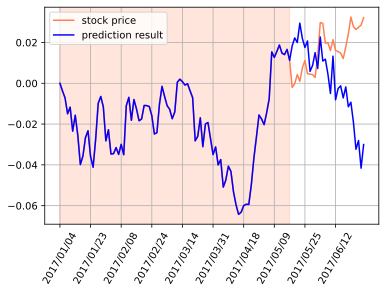

In [26]:
def plot_result():

  # 初期の入力値
  res = []
  res = np.append(res, l_x[0][0][0])
  res = np.append(res, l_y[0].reshape(-1))
  
  for i in range(0, n):
    _y = model.predict(res[- NUM_LSTM:].reshape(1, NUM_LSTM, 1))
    
    # 予測されたデータを次の予測のためのインプットデータとして利用
    res = np.append(res, _y[0][NUM_LSTM - 1][0])
  
  res = np.delete(res, -1)  
  
  plt.plot(date, y, label="stock price", color='coral')
  plt.plot(date, res, label="prediction result", color='blue')
  plt.xticks(date[::12], rotation=60)
  
  plt.legend()
  plt.grid()
  
  plt.axvspan(0, NUM_LSTM, color="coral", alpha=0.2)
  
  plt.show()
  
print('{} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
plot_result()

結果としてはどうでしょうか？まぁトレンドは大きく外していないかなという程度でしょうか笑

### 他の期間の予測

これまでの関数を使って、他の期間の予測もしてみます。

予測期間 : 2017/06/28 - 2017/11/07 の結果


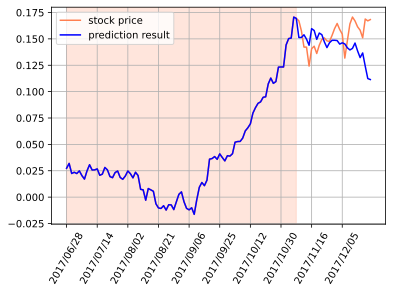

予測期間 : 2017/12/21 - 2018/05/08 の結果


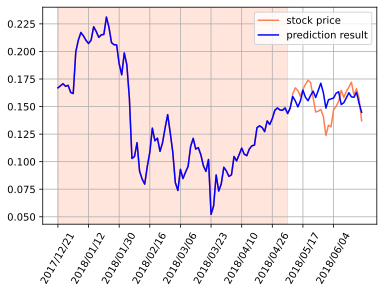

予測期間 : 2018/06/20 - 2018/10/29 の結果


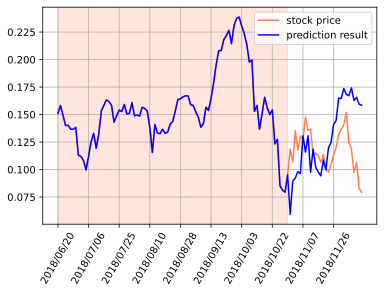

予測期間 : 2018/12/12 - 2019/04/26 の結果


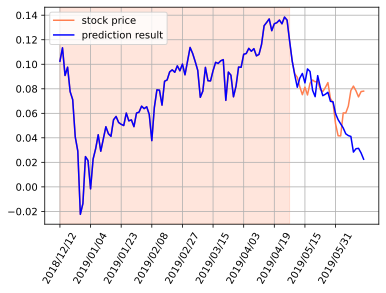

予測期間 : 2019/06/18 - 2019/10/29 の結果


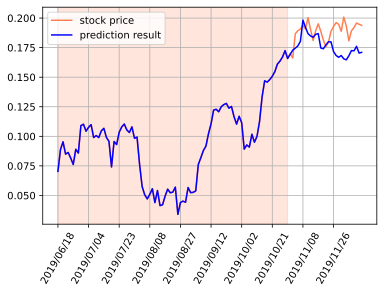

予測期間 : 2019/12/12 - 2020/04/27 の結果


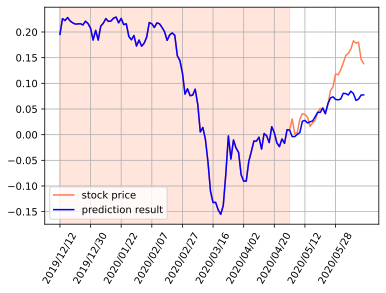

In [27]:
for term in [1, 2, 3, 4, 5, 6]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(term)
  model = build_model('RNN')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

### LSTMによる予測

予測期間 : 2017/01/04 - 2017/05/16 の結果


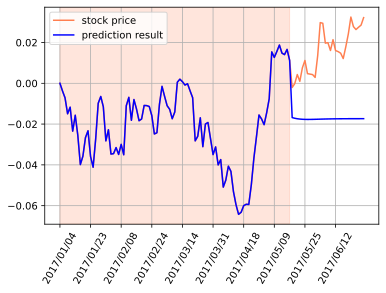

予測期間 : 2017/06/28 - 2017/11/07 の結果


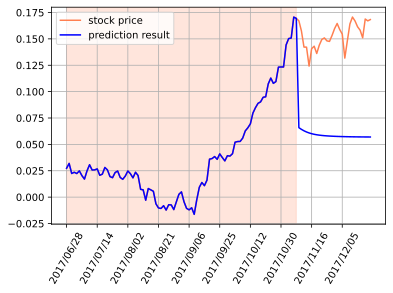

In [28]:
for term in [0, 1]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(term)
  model = build_model('LSTM')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

LSTMでは今回の行った簡単なモデルでは、ほとんど予測できませんでした。よってグラフも二つしか示していません。もう少し考察すれば良さそうですが、今回の目的からはそれるので辞めておきます。

### GRUによる予測

予測期間 : 2017/01/04 - 2017/05/16 の結果


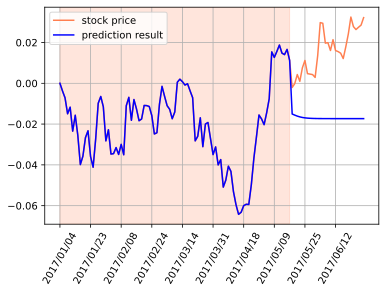

予測期間 : 2017/06/28 - 2017/11/07 の結果


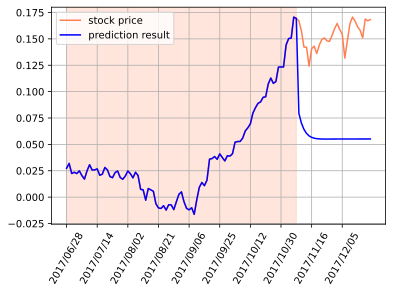

In [29]:
for term in [0, 1]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(term)
  model = build_model('GRU')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

GRUでも意味のある結果が得られませんでした。

## S&P500の予測

### 2019年
同じようにアメリカの代表的な株価指数であるS&P500についても予測してみます。
ファイルは上記のサイトからダウンロード出来ます。

In [30]:
!ls

files_bk             lstm_nb.md           lstm_nb.txt          nikkei.csv           sp500_2019.csv       sp500_2019_utf8.csve sp500_2020_utf8.csv
lstm_nb.ipynb        lstm_nb.py           lstm_nb_files        nikkei_utf8.csv      sp500_2019_utf8.csv  sp500_2020.csv       sp500_2020_utf8.csve


ファイルの中身を簡単に見てみます。

In [31]:
%%bash
head sp500_2019.csv

1557 ����ETF SPDR S&P500  ETF�iETF�j,,,,,
���t,�n�l,���l,���l,�I�l,�o����,�I�l�����l
"2019-01-04","26620","26830","26310","26780","7665","26780"
"2019-01-07","27710","27790","27450","27520","1568","27520"
"2019-01-08","27800","28020","27760","27910","2051","27910"
"2019-01-09","27960","28300","27960","28210","2557","28210"
"2019-01-10","28050","28050","27600","27830","7270","27830"
"2019-01-11","28300","28300","27950","28150","1584","28150"
"2019-01-15","28100","28300","28080","28210","7142","28210"
"2019-01-16","28430","28430","28260","28300","936","28300"


文字コードがShift-JISのようなので、utf-8に置換します。

In [32]:
%%bash
nkf -w sp500_2019.csv > sp500_2019_utf8.csv

さらに見てみると、1行目がpandasに入れるのに余計なので、削除します。

In [33]:
%%bash
head sp500_2019_utf8.csv

1557 東証ETF SPDR S&P500  ETF（ETF）,,,,,
日付,始値,高値,安値,終値,出来高,終値調整値
"2019-01-04","26620","26830","26310","26780","7665","26780"
"2019-01-07","27710","27790","27450","27520","1568","27520"
"2019-01-08","27800","28020","27760","27910","2051","27910"
"2019-01-09","27960","28300","27960","28210","2557","28210"
"2019-01-10","28050","28050","27600","27830","7270","27830"
"2019-01-11","28300","28300","27950","28150","1584","28150"
"2019-01-15","28100","28300","28080","28210","7142","28210"
"2019-01-16","28430","28430","28260","28300","936","28300"


In [34]:
%%bash
sed -ie '1d' sp500_2019_utf8.csv 

In [35]:
%%bash
head sp500_2019_utf8.csv

日付,始値,高値,安値,終値,出来高,終値調整値
"2019-01-04","26620","26830","26310","26780","7665","26780"
"2019-01-07","27710","27790","27450","27520","1568","27520"
"2019-01-08","27800","28020","27760","27910","2051","27910"
"2019-01-09","27960","28300","27960","28210","2557","28210"
"2019-01-10","28050","28050","27600","27830","7270","27830"
"2019-01-11","28300","28300","27950","28150","1584","28150"
"2019-01-15","28100","28300","28080","28210","7142","28210"
"2019-01-16","28430","28430","28260","28300","936","28300"
"2019-01-17","28500","28900","28420","28420","966","28420"


準備が整ったので、pandasに入れます。

In [36]:
df = pd.read_csv('sp500_2019_utf8.csv')

In [37]:
df.head()

,日付,始値,高値,安値,終値,出来高,終値調整値
0,2019-01-04,26620,26830,26310,26780,7665,26780
1,2019-01-07,27710,27790,27450,27520,1568,27520
2,2019-01-08,27800,28020,27760,27910,2051,27910
3,2019-01-09,27960,28300,27960,28210,2557,28210
4,2019-01-10,28050,28050,27600,27830,7270,27830


In [38]:
df.tail()

,日付,始値,高値,安値,終値,出来高,終値調整値
236,2019-12-24,35200,35200,35150,35150,2432,35150
237,2019-12-25,35150,35200,35050,35050,2052,35050
238,2019-12-26,35150,35250,35150,35200,2276,35200
239,2019-12-27,35450,35500,35350,35500,2787,35500
240,2019-12-30,35400,35450,35250,35250,3542,35250


日経平均と同様に、終値を変化率に変換します。同じ関数を利用します。

In [39]:
df['data_list'] = shape_data(df['終値'])

また、先ほどの関数を再利用したいので、日付というカラム名をデータ日付と言うカラム名に変更します。

In [40]:
df = df.rename(columns={'日付':'データ日付'})

In [41]:
df.head()

,データ日付,始値,高値,安値,終値,出来高,終値調整値,data_list
0,2019-01-04,26620,26830,26310,26780,7665,26780,0.000000
1,2019-01-07,27710,27790,27450,27520,1568,27520,0.027633
2,2019-01-08,27800,28020,27760,27910,2051,27910,0.042196
3,2019-01-09,27960,28300,27960,28210,2557,28210,0.053398
4,2019-01-10,28050,28050,27600,27830,7270,27830,0.039208


In [42]:
df.tail()

,データ日付,始値,高値,安値,終値,出来高,終値調整値,data_list
236,2019-12-24,35200,35200,35150,35150,2432,35150,0.312547
237,2019-12-25,35150,35200,35050,35050,2052,35050,0.308813
238,2019-12-26,35150,35250,35150,35200,2276,35200,0.314414
239,2019-12-27,35450,35500,35350,35500,2787,35500,0.325616
240,2019-12-30,35400,35450,35250,35250,3542,35250,0.316281


全体のグラフを俯瞰しています。

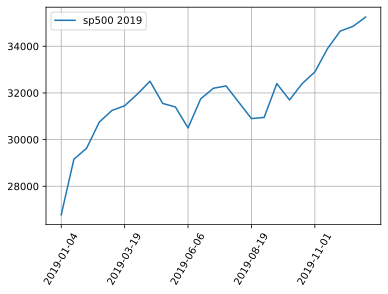

In [43]:
plt.plot(df['データ日付'][::ticks], df['終値'][::ticks], label='sp500 2019')
plt.grid()
plt.legend()
plt.xticks(df['データ日付'][::xticks], rotation=60)
plt.show()

予測を行って、結果をグラウかしてみます。

予測期間 : 2019-01-04 - 2019-05-22 の結果


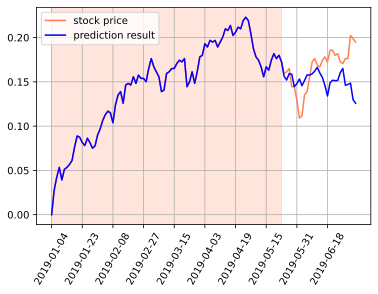

予測期間 : 2019-07-04 - 2019-11-15 の結果


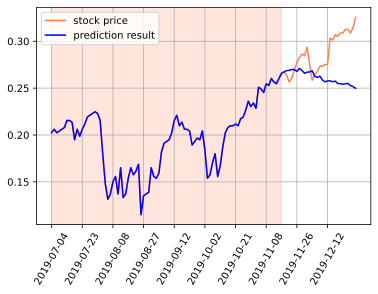

In [44]:
for term in [0, 1]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(term)
  model = build_model('RNN')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

日経平均と同様、トレンドに沿って予測しており、逆張り防止にはなるかもしれません笑

### 2020年

次に2020年の株価について予測を行ってみます。データの前処理などは省略します。

In [45]:
%%bash
head sp500_2020_utf8.csv
nkf -w sp500_2020.csv > sp500_2020_utf8.csv
sed -ie '1d' sp500_2020_utf8.csv 

日付,始値,高値,安値,終値,出来高,終値調整値
"2020-01-06","34800","34850","34700","34750","7632","34750"
"2020-01-07","35050","35200","35050","35200","3487","35200"
"2020-01-08","34550","34900","34200","34850","11349","34850"
"2020-01-09","35450","35600","35450","35600","6255","35600"
"2020-01-10","35850","35900","35800","35900","3461","35900"
"2020-01-14","36200","36250","36100","36150","4379","36150"
"2020-01-15","35950","36050","35900","35950","4270","35950"
"2020-01-16","36150","36250","36100","36250","2707","36250"
"2020-01-17","36500","36550","36450","36450","9618","36450"


In [46]:
df = pd.read_csv('sp500_2020_utf8.csv')
df.head()

,日付,始値,高値,安値,終値,出来高,終値調整値
0,2020-01-06,34800,34850,34700,34750,7632,34750
1,2020-01-07,35050,35200,35050,35200,3487,35200
2,2020-01-08,34550,34900,34200,34850,11349,34850
3,2020-01-09,35450,35600,35450,35600,6255,35600
4,2020-01-10,35850,35900,35800,35900,3461,35900


In [47]:
df['data_list'] = shape_data(df['終値'])
df = df.rename(columns={'日付':'データ日付'})
df.head()

,データ日付,始値,高値,安値,終値,出来高,終値調整値,data_list
0,2020-01-06,34800,34850,34700,34750,7632,34750,0.000000
1,2020-01-07,35050,35200,35050,35200,3487,35200,0.012950
2,2020-01-08,34550,34900,34200,34850,11349,34850,0.002878
3,2020-01-09,35450,35600,35450,35600,6255,35600,0.024460
4,2020-01-10,35850,35900,35800,35900,3461,35900,0.033094


In [48]:
df.tail()

,データ日付,始値,高値,安値,終値,出来高,終値調整値,data_list
234,2020-12-21,38250,38300,38100,38300,6596,38300,0.102158
235,2020-12-22,38000,38100,37800,37900,6080,37900,0.090647
236,2020-12-24,38050,38200,38050,38100,2621,38100,0.096403
237,2020-12-25,38300,38300,38100,38200,1945,38200,0.099281
238,2020-12-28,38250,38450,38200,38400,4734,38400,0.105036


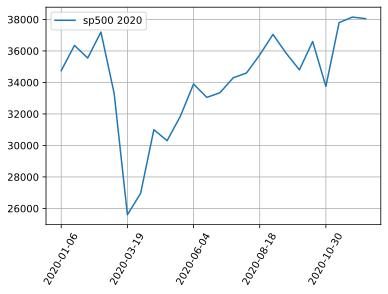

In [49]:
plt.plot(df['データ日付'][::ticks], df['終値'][::ticks], label='sp500 2020')
plt.grid()
plt.legend()
plt.xticks(df['データ日付'][::xticks], rotation=60)
plt.show()

予測期間 : 2020-01-06 - 2020-05-20 の結果


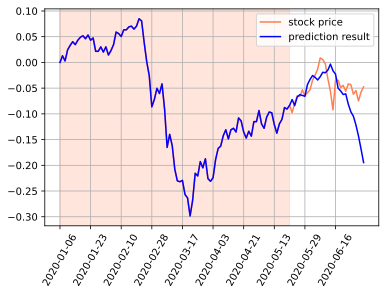

予測期間 : 2020-07-02 - 2020-11-13 の結果


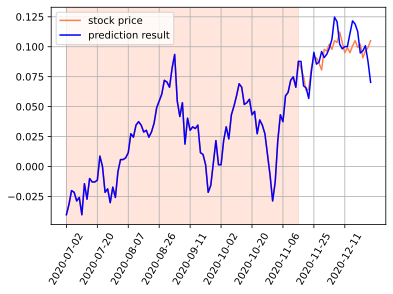

In [50]:
for term in [0, 1]:
  n, date, x, y, l_x, l_y = get_x_y_lx_ly(term)
  model = build_model('RNN')
  history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
  print('予測期間 : {} - {} の結果'.format(date[0], date[NUM_LSTM - 1]))
  plot_result()

## まとめ

特徴量抽出、モデル検討、ハイパーパラメタの調整などやれることはたくさんあると思いますが、目的はkerasに慣れる事で、サービスインなどの予定はないので、ここで終わりにします。
株価を決定する要素は様々あるので、単純なNNでは予測するのはかなり難しいだろうと思っています。